In [1]:
from dataclasses import replace
import random
from collections import Counter

from replenishment import (
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    compute_backtest_rmse_by_article,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_service_level_factors,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment_for_articles,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_to_dataframe,
)

# Mean Forecast: Fill Rate
This notebook treats `sigma` as a probability (cycle fill rate) and compares:  
1) optimizing sigma only,  
2) optimizing sigma + aggregation window.


## 1) Generate Sample Data
We generate synthetic history + forecast rows. Forecast periods are given simulated actuals so we can compare forecast vs. actuals in evaluation.


In [2]:

history_mean = 20.0
history_std = 8.0
forecast_mean = 18.0
forecast_std = 6.0

rows = generate_standard_simulation_rows(
    n_unique_ids=200,
    periods=120,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    forecast_start_period=60,
    lead_time=3,    
    initial_on_hand=25,
    current_stock=25,
    holding_cost_per_unit=1,
    stockout_cost_per_unit=5,
    order_cost_per_order=10,
)

backtest_rows, evaluation_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/evaluation period.
rng = random.Random(7)
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

evaluation_rows_actuals = []
for row in evaluation_rows:
    actual = _sample_int(history_mean, history_std)
    evaluation_rows_actuals.append(replace(row, actuals=actual, demand=actual))

evaluation_rows = evaluation_rows_actuals

rows_df = standard_simulation_rows_to_dataframe(
    backtest_rows + evaluation_rows, library="pandas"
)
print(f"backtest rows: {len(backtest_rows)}, forecast rows: {len(evaluation_rows)}")
if not evaluation_rows:
    raise ValueError("No forecast rows found. Set forecast_start_period to create forecast rows.")

candidate_service_levels = [.1, .12, .14, .16, .18, .2, .22, .24, .26, .28, .3, .32, .34, .36, .38, .4, .42,  .5, 
                       .6, .62, .64, .66, .68, 0.7, .72, .74, .76, 
                       .78, 0.8, .82, .84, .86, .88, .90, .92, .94, .96, .99
                       ]
candidate_windows = [3, 6, 9]


backtest rows: 12000, forecast rows: 12000


## 2) Optimize Sigma Only (Fill Rate)


In [3]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=candidate_service_levels[0],
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
)

optimized = optimize_service_level_factors(
    point_configs,
    candidate_factors=candidate_service_levels,
    service_level_mode="fill_rate",
)

best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]

eval_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
    actuals_override=backtest_actuals,
)
eval_simulations = simulate_replenishment_for_articles(eval_configs)
eval_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    eval_simulations,
    sigma=best_factors,
    fixed_rmse=backtest_rmse,
    service_level_mode="fill_rate",
)


In [4]:
sigma_decisions_df = replenishment_decision_rows_to_dataframe(eval_decisions)
sigma_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,69,18,20,77,75.585035,95.585035,0,25,...,5.585035,25,7,7,69,0,0,0.94,1,None
1,A,2029-01-04,13,24,25,72,81.482253,106.482253,0,7,...,4.482253,7,0,0,82,0,17,0.94,1,None
2,A,2029-02-03,0,18,25,54,77.262379,102.262379,0,0,...,5.262379,0,0,0,82,0,18,0.94,1,None
3,A,2029-03-05,0,17,27,37,62.437623,89.437623,69,69,...,8.437623,69,52,52,13,0,0,0.94,1,None
4,A,2029-04-04,0,13,20,33,49.258922,69.258922,13,65,...,12.258922,65,52,52,0,0,0,0.94,1,None


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7     18
8     15
9      0
10     5
11    11
12     0
13     0
14     0
15    10
16     0
17     0
18     0
19     0
20     3
21     3
22     6
23     0
24     0
25     6
26     0
27     0
28     0
29    23
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     4
40     3
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50    10
51     1
52     0
53     0
54     0
55     9
56     6
57     2
58     0
59     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

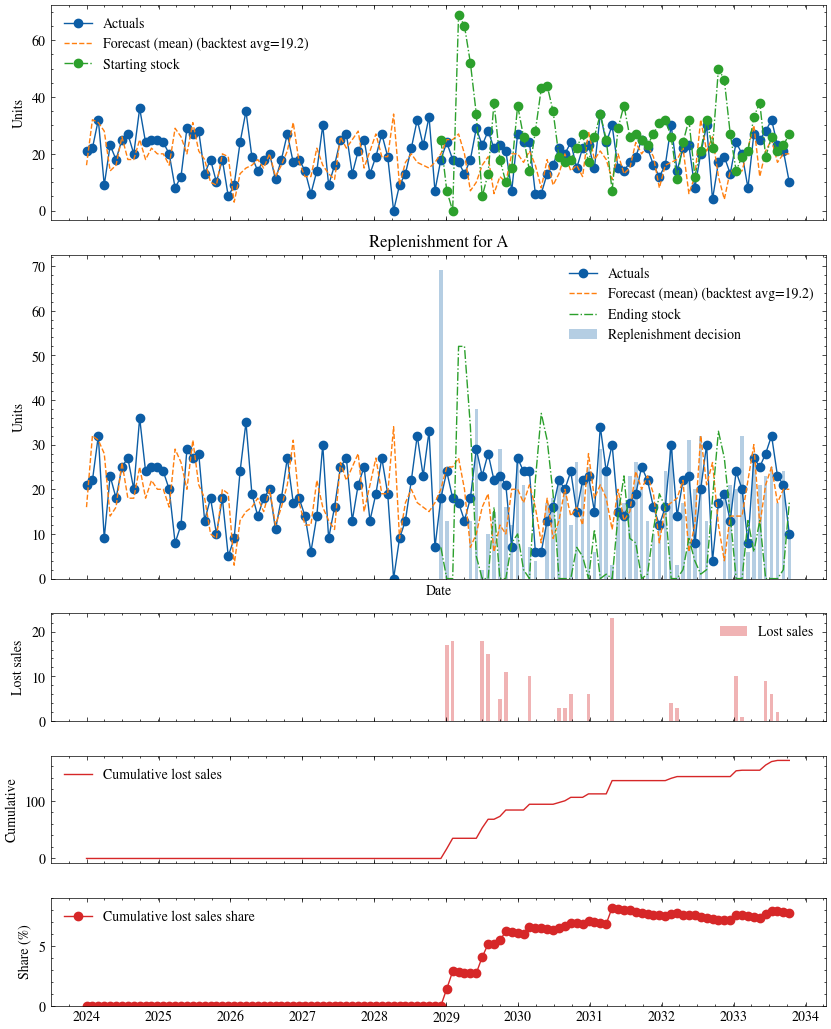

In [5]:
example_id = sigma_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, sigma_decisions_df, unique_id=example_id)


## 3) Optimize Sigma + Aggregation Window


In [6]:
candidate_windows

[3, 6, 9]

In [7]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=candidate_service_levels,
    service_level_mode="fill_rate",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="fill_rate",
)


In [8]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)
agg_decisions_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,118,18,23.333333,41.333333,124.509233,194.509233,0,25,...,54.509233,25,7,7,118,0,0,0.99,3,None
1,A,2029-01-04,0,24,25.666667,38.000000,130.176055,207.176055,0,7,...,53.176055,7,0,0,118,0,17,0.99,3,None
2,A,2029-02-03,0,18,24.000000,35.000000,126.117031,198.117031,0,0,...,54.117031,0,0,0,118,0,18,0.99,3,None
3,A,2029-03-05,12,17,18.000000,33.000000,112.052411,166.052411,118,118,...,58.052411,118,101,101,12,0,0,0.99,3,None
4,A,2029-04-04,0,13,12.333333,26.000000,100.005612,137.005612,0,101,...,63.005612,101,88,88,12,0,0,0.99,3,None


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    11
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29    10
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

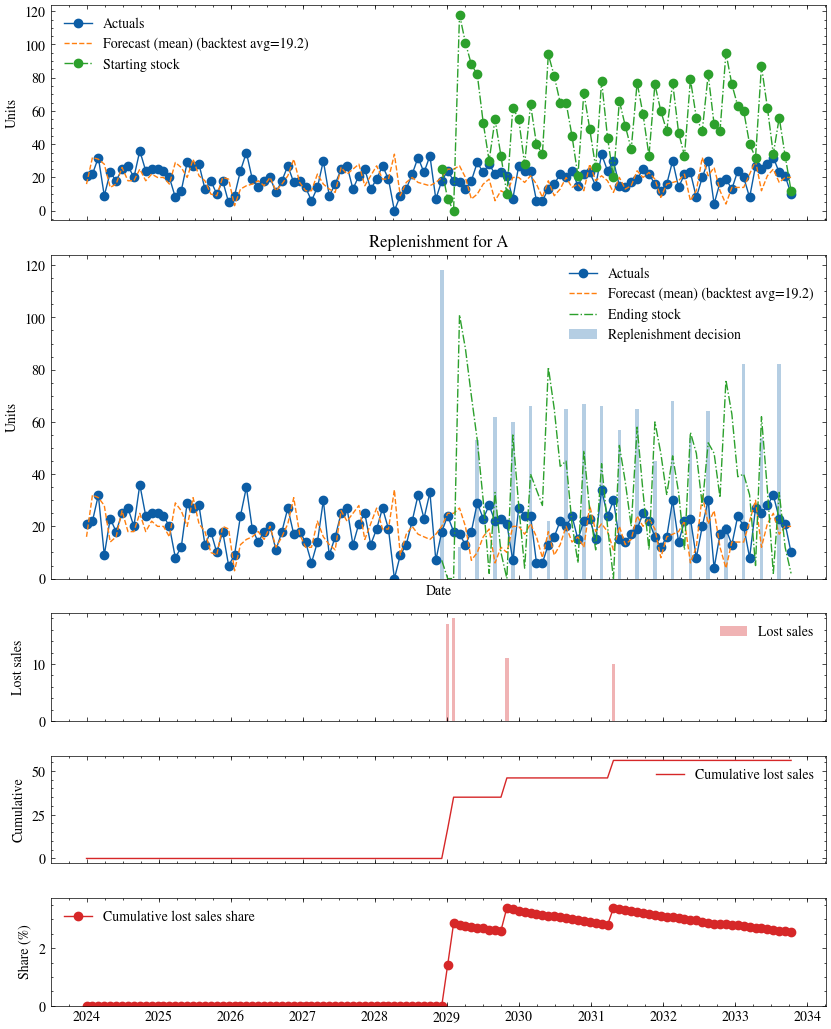

In [9]:
example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)


### Take a given fill rate and optimize aggregation windows

In [10]:
candidate_windows

[3, 6, 9]

In [11]:
backtest_rmse = compute_backtest_rmse_by_article(backtest_rows)

point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=.95,
    service_level_mode="fill_rate",
    fixed_rmse=backtest_rmse,
)

agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=candidate_windows,
    candidate_factors=[.95],
    service_level_mode="fill_rate",
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

agg_backtest_rmse = compute_backtest_rmse_by_article(
    backtest_rows,
    aggregation_window=agg_windows,
)

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    evaluation_rows,
    service_level_factor=agg_best_factors,
    service_level_mode="fill_rate",
    fixed_rmse=agg_backtest_rmse,
    actuals_override=backtest_actuals,
)
agg_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_decisions = build_replenishment_decisions_from_simulations(
    evaluation_rows,
    agg_simulations,
    aggregation_window=agg_windows,
    sigma=agg_best_factors,
    fixed_rmse=agg_backtest_rmse,
    service_level_mode="fill_rate",
)


0      0
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8     23
9      0
10     0
11    12
12     0
13     0
14    17
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     3
23    15
24     0
25     0
26     0
27     0
28     5
29    30
30     0
31     0
32     0
33     0
34     0
35    13
36     0
37     0
38     0
39     0
40     0
41    13
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53    17
54     0
55     0
56     6
57     0
58     7
59    10
Name: missed_sales, dtype: int64


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2028-12-05,93,18,23.333333,41.333333,99.015388,169.015388,0,25,...,29.015388,25,7,7,93,0,0,0.95,3,None
1,A,2029-01-04,0,24,25.666667,38.000000,104.252208,181.252208,0,7,...,27.252208,7,0,0,93,0,17,0.95,3,None
2,A,2029-02-03,0,18,24.000000,35.000000,100.498043,172.498043,0,0,...,28.498043,0,0,0,93,0,18,0.95,3,None
3,A,2029-03-05,12,17,18.000000,33.000000,87.640387,141.640387,93,93,...,33.640387,93,76,76,12,0,0,0.95,3,None
4,A,2029-04-04,0,13,12.333333,26.000000,76.971706,113.971706,0,76,...,39.971706,76,63,63,12,0,0,0.95,3,None


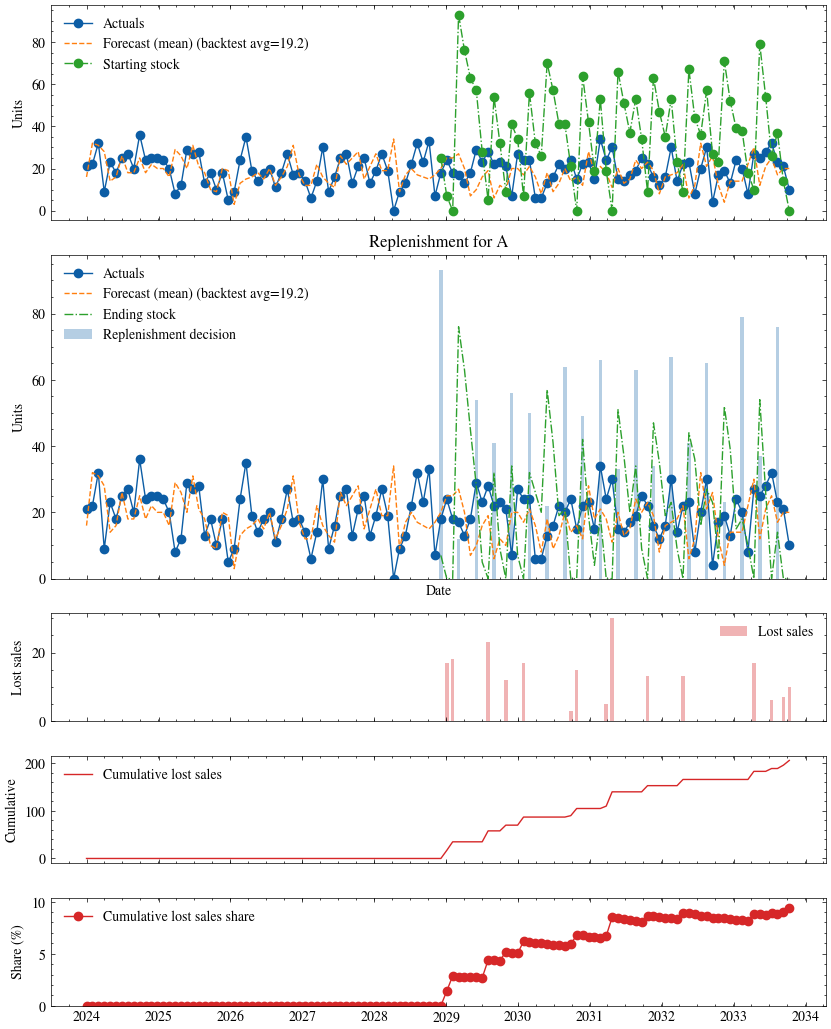

In [12]:
agg_decisions_df = replenishment_decision_rows_to_dataframe(agg_decisions)

example_id = agg_decisions_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, agg_decisions_df, unique_id=example_id)

agg_decisions_df.head()

In [13]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['missed_sales'].sum()

np.int64(21410)

In [14]:
agg_decisions_df[agg_decisions_df.ds > '2026-06-19']['demand'].sum()

np.int64(240519)